# ATTENTION: a couple things need to be changed once the library is ready.

Here is a list:
- the first import, it should simply import the functionalities needed as if hnx is installed, not using `sys.path.append`
- the data loading below needs to be changed, ideally, we would only used the utilities provided within the library

In [1]:
import sys
from collections import Counter

import numpy as np
import matplotlib.pyplot as plt

sys.path.append("..")
from hnx.communities.hy_mmsbm.model import HyMMSBM
from hnx.core.hypergraph import Hypergraph
from hnx.generation.hy_mmsbm_sampling import HyMMSBMSampler
from hnx.linalg.linalg import binary_incidence_matrix

np.random.seed(123)

# Sampling from the *Hy-MMSBM* generative model

In this tutorial we will show how to sample synthetic hypergraphs from *Hy-MMSBM* generative model, presented in 

*A Principled, Flexible and Efficient Framework for Hypergraph Benchmarking* <br />
Ruggeri et al. (2022)

## Vanilla sampling from the generative model

The most vanilla type of sampling can be performed by only providing the affinity matrix $w$ and community assignments $u$, and sampling from the distribution $p(A; w, u)$, where $A$ is the array of hyperedge weights (possibly zero) for all possible exisiting hyperedges.

For example, assume we want to sample a hypergraph with $N=60$ nodes and $K=3$ equally-sized assortative communities. In addition, we need to decide the maximum size of the hyperedges that we want to generate. Then, we can obtain a synthetic hypegraph as following.

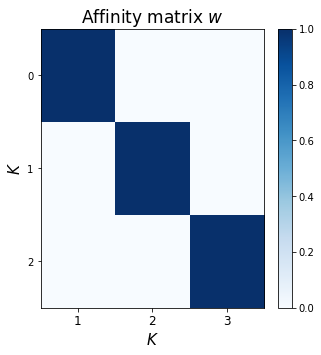

In [2]:
# Diagonal affinity matrix, which results in an assortative structure
w = np.eye(3)

plt.matshow(w, aspect='auto', cmap='Blues')
plt.gcf().set_size_inches(5, 5)
plt.title(r'Affinity matrix $w$', fontsize=17)
plt.xlabel(r'$K$', fontsize=15)
plt.ylabel(r'$K$', fontsize=15)
plt.xticks(ticks=[0,1,2], labels=[1,2,3], size=12)
plt.tick_params(axis='x', bottom=True, top=False, labelbottom=True, labeltop=False)
plt.colorbar()
plt.show()

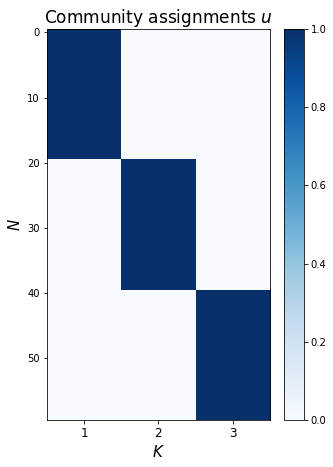

In [3]:
# Community assignments
u = np.zeros((60, 3))
u[:20, 0] = 1
u[20:40, 1] = 1
u[40:, 2] = 1

plt.matshow(u, aspect='auto', cmap='Blues')
plt.gcf().set_size_inches(5, 7)
plt.title(r'Community assignments $u$', fontsize=17)
plt.xlabel(r'$K$', fontsize=15)
plt.ylabel(r'$N$', fontsize=15)
plt.xticks(ticks=[0,1,2], labels=[1,2,3], size=12)
plt.tick_params(axis='x', bottom=True, top=False, labelbottom=True, labeltop=False)
plt.colorbar()
plt.show()

Notice that the generative parameters are very general: 
- the affinity $w$ can be any symmetric $K \times K$ non-nagative matrix 
- the assignments $u$ can be any $N \times K$ non-negative matrix, allowing for mixed-membership as well

Now initialize the model.

In [4]:
sampler = HyMMSBMSampler(
    w=w, 
    u=u,
    max_hye_size=10,
)
sample_generator = sampler.sample()

Now start the sampling. Recall that the most general form of sampling work as following:
- sample the degree and dimension sequences 
- arrange them in a first hypergraph proposal
- mix the hyperedges of the initial proposal via a Markov Chain, and continuously return the results at different steps of the chain

Since the Markov Chain can be continuously mixed, the number of samples is unlimited and is represented by a generator, as opposed to a finite-length list. 

In [5]:
%%time

for i in range(10):
    print("Getting sample number:", i)
    new_sample = next(sample_generator)

# Get some more samples later in the code
print("Getting another couple of samples...")
_ = next(sample_generator)
_ = next(sample_generator)

Getting sample number: 0


KeyError: 'Object (0, 16, 52) already exists.'

The obtained samples are a `hnx.core.hypergraph.Hypergraph` instance.

In [ ]:
sample = next(sample_generator)
print(f"Extracted sample with N={sample.num_nodes()} nodes and |E|={sample.num_edges()} hyperedges.")

Extracted sample with N=60 nodes and |E|=820 hyperedges.


Notice, however, that all the samples generated from the same call of `HyMMSBMSampler.sample` will have the same degree and size sequence. To have a completely new sample, a new call to the method is needed.

## Conditioning the sampling with additional inputs

There are two main ways to further condition the sampling procedure:
- by providing a degree sequence or a size sequence (or both);
- by providing an existing hypergraph to condition on.

#### 1. Providing input sequences

The degree sequence is a numpy array of length $N$, specifying the degree of each node. 
The dimension sequence is a dictionary with key-value pairs `{size: count}` specifying the number of the hyperedges of every given size.

If one of these sequences is provided, then all the samples will respect it *exactly*. If both are provided, then one is modified in case they are not compatible. However, in case both are provided and come from an already existing hypergraph, we suggest directly providing the hypergraph as input (see next section).

For example, to provide the degree sequence:

In [ ]:
w = np.eye(3)
u = np.zeros((200, 3))
u[:66, 0] = 1
u[66:133, 1] = 1
u[133:, 2] = 1

deg_seq = np.random.randint(low=1, high=5, size=200)

sampler = HyMMSBMSampler(
    w=w, 
    u=u,
    max_hye_size=4,
)
sample_generator = sampler.sample(deg_seq=deg_seq)
sample = next(sample_generator)

print(
    "Does the sample have same degree sequence as the input one?", 
    np.all(binary_incidence_matrix(sample).sum(axis=1) == deg_seq)
)

Does the sample have same degree sequence as the input one? True


../hnx/generation/hy_mmsbm_sampling.py:131: RuntimeWarning: divide by zero encountered in log
  log_poisson = np.log(


Notice that, due to the approximations in the MCMC procedure, sometimes the degree sequence in the samples could very slightly deviate from the input one. 

Similarly, to provide the dimension sequence:

In [ ]:
# 10 hyperedges of size 3, 7 hyperedges of size 4, etc...
dim_seq = {
    3: 10,
    4: 7,
    7: 5,
    9: 5,
    12: 3,
}

sampler = HyMMSBMSampler(
    w=w, 
    u=u,
    max_hye_size=4,
)
sample_generator = sampler.sample(dim_seq=dim_seq)
sample = next(sample_generator)

print(
    "Does the sample have same dimension sequence as the input one?", 
    dict(Counter(len(hye) for hye in sample)) == dim_seq
)

Does the sample have same dimension sequence as the input one? True


#### 2. Providing an input hypergraph

Providing a hypergraph as input is statically equivalent to providing its degree and size sequence, however computationally much cheaper.

For example, one can condition on the Justice dataset but use arbitrary $w, u$. In this case, we provide the initial configuration of the Markov Chain as the list of hyperedges observed in the data.

# TODO CHANGE DATASET LOADING HERE

In [ ]:
def line_to_hyperedge(line):
    hye = line
    hye = line.strip("\n")
    hye = [int(node) for node in line.split(" ")]
    return hye

# Load Justice dataset.
with open("./_example_data/justice_data/hyperedges.txt", "r") as hye_file:
    with open("./_example_data/justice_data/weights.txt", "r") as weight_file:
        justice = Hypergraph([
            line_to_hyperedge(hye)
            for hye, weight in zip(hye_file.readlines(), weight_file.readlines())
        ])

N = justice.num_nodes()
K = 2  # arbitrarily chosen

w = np.eye(K)
# Random hard community assignments.
u = np.zeros((N, K))
u[np.arange(N), np.random.randint(0, K, size=N)] = 1  

In [ ]:
model = HyMMSBMSampler(
    u=u, 
    w=w,
)
sample_generator = model.sample(initial_hyg=justice)
_ = next(sample_generator)

## Pre-adjusting the expected statistics

Many times, providing $w, u$ has no clear implications on the expected statistics of the model. 

For example, we might want to rescale the parameters so as to obtain a given expected degree. This can be done prior to sampling, since the expected degree can be computed in closed form, and is linear in $w$ (or quadratic in $u$). The rescaled parameters can then be used for sampling as normal.

Take once again the simple case of three equally-sized and assortative communities.

In [ ]:
# Diagonal affinity matrix
w = np.eye(3)

# Community assignments
u = np.zeros((60, 3))
u[:20, 0] = 1
u[20:40, 1] = 1
u[40:, 2] = 1

max_hye_size=10

model = HyMMSBM(
    u=u, 
    w=w,
    max_hye_size=max_hye_size
)
orig_deg = model.expected_degree()
orig_deg

53.75039682539682

To obtain, for example, an expected degree of 100, one can simply rescale $w$ or $u$.

In [ ]:
new_deg = 100

rescaled_w = w / orig_deg * new_deg
new_w_model = model = HyMMSBM(
    u=u, 
    w=rescaled_w,
    max_hye_size=max_hye_size
)
print("Expected degree when rescaling w:", new_w_model.expected_degree())

rescaled_u = u / np.sqrt(orig_deg) * np.sqrt(new_deg)
new_u_model = HyMMSBM(
    u=rescaled_u, 
    w=w,
    max_hye_size=max_hye_size
)
print("Expected degree when rescaling u:", new_u_model.expected_degree())

Expected degree when rescaling w: 100.0
Expected degree when rescaling u: 100.00000000000001
